In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from diffdrr import DRR, load_example_ct
from diffdrr.metrics import XCorr2
from diffdrr.visualization import plot_drr

from loss import GenLoss

In [2]:
# Read in the volume
volume, spacing = load_example_ct()

# Get parameters for the detector
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
params = {
    "sdr"   : 200.0,
    "theta" : np.pi,
    "phi"   : 0,
    "gamma" : np.pi / 2,
    "bx"    : bx,
    "by"    : by,
    "bz"    : bz,
}
true_params = torch.tensor([list(params.values())[1:]], dtype=torch.float32, device="cuda")

# Make the DRR
drr = DRR(volume, spacing, height=100, delx=5e-2, device="cuda")
img = drr(**params)

tensor([[  3.1416,   0.0000,   1.5708, 180.0000, 180.0000, 166.2500]],
       device='cuda:0')


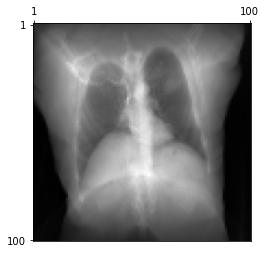

In [3]:
print(true_params)
plot_drr(img)
plt.show()

In [4]:
class Model(nn.Module):
    def __init__(self, dtype=torch.float32, device="cuda"):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, dtype=dtype, device=device)
        self.conv2 = torch.nn.Conv2d(6, 16, 5, dtype=dtype, device=device)
        self.pool = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(16 * 22 * 22, 120, dtype=dtype, device=device)
        self.fc2 = torch.nn.Linear(120, 84, dtype=dtype, device=device)
        self.fc3 = torch.nn.Linear(84, 6, dtype=dtype, device=device)

    def forward(self, x):
        x = x.view(-1, 1, 100, 100)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        return torch.tensor(x.shape[1:]).prod().item()

In [22]:
# Initialize loss and model
model = Model()
loss_func = torch.nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=3e-10)

In [148]:
# Zero the gradients for each batch
model.train(True)
opt.zero_grad()

# Make predictions of the batch
est_params = model(img)
print(est_params)

# Compute loss and its gradient
loss = loss_func(est_params, true_params)
loss.backward(retain_graph=True)
print(loss)
# print([b.sum() for b in model.parameters()])

# Adjust the weights
opt.step()

tensor([[3.0781e+00, 3.0120e-02, 1.5085e+00, 1.7996e+02, 1.8001e+02, 1.6624e+02]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


In [152]:
drr(200.0, *est_params)

ValueError: only one element tensors can be converted to Python scalars

In [48]:
class GenLoss(nn.Module):
    def __init__(self, drr, sdr=200.0, zero_mean_normalized=True):
        super(GenLoss, self).__init__()
        self.drr = drr
        self.sdr = sdr
        self.xcorr2 = XCorr2(zero_mean_normalized)

    def forward(self, est_params, true_params):
        est = self.drr(self.sdr, *est_params.detach().cpu().tolist()[0])
        true = self.drr(self.sdr, *true_params.detach().cpu().tolist()[0])
        loss = -self.xcorr2(est, true)
        return loss, est, true

In [ ]:
loss_func = GenLoss(drr)

# Zero the gradients for each batch
model.train(True)
opt.zero_grad()

# Make predictions of the batch
est_params = model(img)
print(est_params)

# Compute loss and its gradient
loss, est_drr, true_drr = loss_func(est_params, true_params)
loss.backward()
print(loss)
# print([b.sum() for b in model.parameters()])

# Adjust the weights
opt.step()

fig, axs = plt.subplots(ncols=2)
plot_drr(est_drr, ax=axs[0])
plot_drr(true_drr, ax=axs[1])

In [15]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()